# Notes

### I have definitely made some changes already (remember, you can reload the zip if you need to refresh - none of the changes so far are very impressive)
### Challenges: running outside of the Udacity environment
1. File structure is different (though honestly that's just a matter of changing a few paths
2. Adding in custom data is challenging, because it uses a dataloader, which expects an annotated dataset. Details about that can be found [here](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)
3. I'm running on my laptop and don't have a cuda option...all my models were data was pickled on a cuda-supported system, so I can't unpickle them onto a cpu (there is probably a way to convert though)

### Next steps
There are two paths I'm considering (though 1 is quickly becoming the leader):
1. Basically no change to the code (in fact, reload the original from zip). Download the coco data and/or create a custom data set - this is probably the preferred method...I think?
    a. custom data would help to make it more interactive for new users...I would need to find or write a converter to coco format though
    
2. Rip out the annotations, load the images, and figure out how to apply the transforms, or maybe
    a. This code really had that data format built in pretty deeply

# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [5]:

from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
# transform_test = ...
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
#     transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


In [12]:
"""
This cell contains the coco dependencies (I've isolated most the dependencies to this cell)
These are removed for convenience, so that people can tinker with images without needing to download all of COCO
"""
%load_ext autoreload
%autoreload 2
# import sys
# sys.path.append('/opt/cocoapi/PythonAPI')
# from pycocotools.coco import COCO
from data_loader import get_loader

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
# data_loader = get_loader(transform=transform_test,    
#                          mode='test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Vocabulary successfully loaded from vocab.pkl file!


AttributeError: 'CoCoDataset' object has no attribute 'paths'

Run the code cell below to visualize an example test image, before pre-processing is applied.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
print(image.shape)
print(orig_image.shape)
# plt.imshow(np.squeeze(image))
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

NameError: name 'data_loader' is not defined

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [15]:
# data without coco
import os
import pickle
vocab_file = './vocab.pkl'
vocab_from_file = True
if os.path.exists(vocab_file) & vocab_from_file:
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print('Vocabulary successfully loaded from vocab.pkl file!')

Vocabulary successfully loaded from vocab.pkl file!


In [17]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
epoch = 2
step = 2000
encoder_file = f"encoder-{epoch}-{step}.pkl" # TODO: update when all 3 epochs finish 
decoder_file = f"decoder-{epoch}-{step}.pkl" # TODO: update when all 3 epochs finish 

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.

vocab_size = len(vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\OptimizePrime/.cache\torch\checkpoints\resnet50-19c8e357.pth


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

Input shape:  torch.Size([1, 1, 256])
example output: [0, 3, 29, 30, 130, 554, 77, 32, 392, 13, 3, 33, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ""
    for idx in output[1:]:
        word = data_loader.dataset.vocab.idx2word[idx]
        if idx != 1:
             sentence += word + " "

    # Crop extra spaces around the ending punctuation
    punctuation = [".", "?", "!"]
    if sentence[-2] in punctuation:
        sentence = sentence[:-3] + sentence[-2]
        
    sentence = sentence[0].upper() + sentence[1:] # capitalize first letter
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A stop sign is shown in the middle of a street.


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

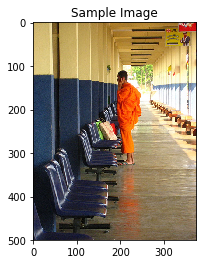

Input shape:  torch.Size([1, 1, 256])
A man is sitting on a bench in the snow.


In [9]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

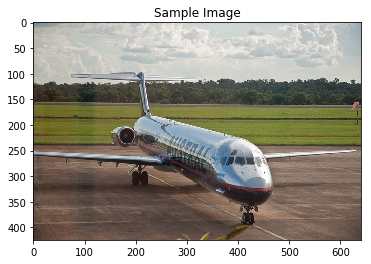

Input shape:  torch.Size([1, 1, 256])
A large passenger plane is parked on the runway.


In [86]:
get_prediction()

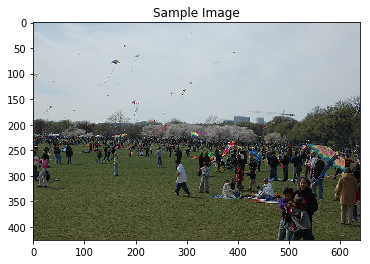

Input shape:  torch.Size([1, 1, 256])
A group of people standing around a field flying kites.


In [10]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

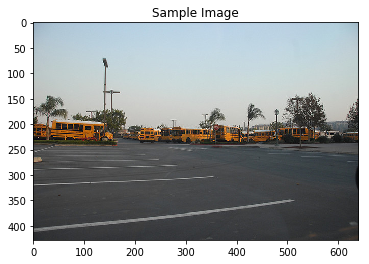

Input shape:  torch.Size([1, 1, 256])
A train is traveling down the track near a building.


In [13]:
get_prediction()

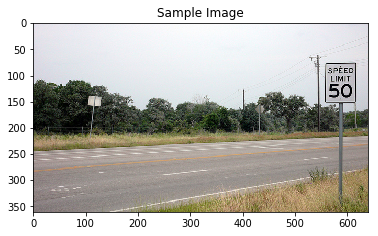

Input shape:  torch.Size([1, 1, 256])
A red stop sign sitting on the side of a road.


In [15]:
get_prediction()

## These are just for fun...

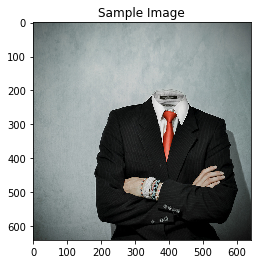

Input shape:  torch.Size([1, 1, 256])
A man wearing a suit and tie is posing for a picture.


In [14]:
get_prediction()

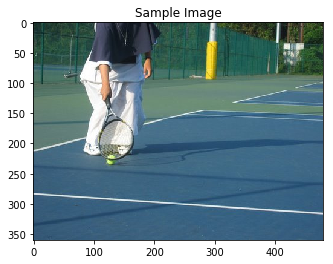

Input shape:  torch.Size([1, 1, 256])
A woman holding a tennis racquet on a tennis court.


In [16]:
get_prediction()

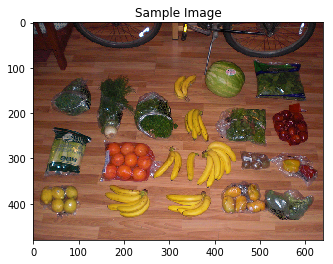

Input shape:  torch.Size([1, 1, 256])
A table filled with lots of different kinds of fruit.


In [158]:
get_prediction()

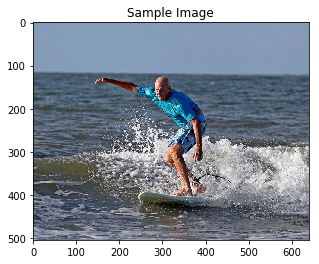

Input shape:  torch.Size([1, 1, 256])
A man riding a wave on a surfboard.


In [136]:
get_prediction()